# CSI5139
* * *
# Assignment 3 | Optical Flow
* * * 
## In this jupyter notebook, I will be dicussing the following
***
- ### [1 Data reading and preparation](#1)
- ### [2 Sequential Model](#2)
    - #### [2.1 Training Parameters](#2_1)
    - #### [2.2 Network Design](#2_2)
    - #### [2.3 Accuracy Metric](#2_3)
    - #### [2.4 Choosing Loss function](#2_4)
    - #### [2.5 Results](#2_5)
- ### [3 Transfer Learning](#3)
    - #### [3.1 Rotation Data](#3_1)
    - #### [3.2 Mix Data](#3_2)
- ### [4 Non-sequential Model](#4)
    - #### [4.1 Rotation Data](#4_1)
    - #### [4.2 Mix Data](#4_2)
- ### [5 Visualizing and comparing the results](#5)
    - #### [5.1 Rotation Data](#5_1)
    - #### [5.2 Mix Data](#5_2)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
'''
    Importing the relevant packages/libraries:
    - tensorflow
    - numpy
    - matplotlib
    - tf.keras -> layers, optimizers, losses, regularizers, metrics, callbacks, utils
'''
%matplotlib inline
%autosave 60
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import colors
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, \
                                    SeparableConv2D, BatchNormalization, \
                                    ELU, ReLU, LeakyReLU, concatenate, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam, Adadelta
from tensorflow.keras.losses import MeanSquaredError, LogCosh
from tensorflow.keras.regularizers import l2
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

Autosaving every 60 seconds


/home/yahyaalaa/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yahyaalaa/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yahyaalaa/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yahyaalaa/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
print(tf.test.gpu_device_name())
print(tf.test.is_gpu_available())
'''
    Code for clearing the GPU after each model
'''
def clear_gpu(model):
    import gc
    K.clear_session()
    gc.collect()
    del model

/device:GPU:0
True


### <a name="1">1. Data reading and preparation</a>
***

In [5]:
'''
    Defining the dataset directory names for rotation data, and the path for the TensorBoard logs
'''
DATASET_DIR      = 'optical_flow_dataset/'

rot_images_train = DATASET_DIR + 'rot_images_train.npy'
rot_flows_train  = DATASET_DIR + 'rot_flows_train.npy'
rot_images_test  = DATASET_DIR + 'rot_images_test.npy'
rot_flows_test   = DATASET_DIR + 'rot_flows_test.npy'

mix_images_train = DATASET_DIR + 'mix_images_train.npy'
mix_flows_train  = DATASET_DIR + 'mix_flows_train.npy'
mix_images_test  = DATASET_DIR + 'mix_images_test.npy'
mix_flows_test   = DATASET_DIR + 'mix_flows_test.npy'

TB_LOG_DIR       = 'TB_logs/'
LOG_DIR          = 'logs/'

In [6]:
'''
    Loading the rotation training and testing data into numpy arrays using np.load(...)
'''
rot_train_images = np.load(rot_images_train)
rot_train_flows  = np.load(rot_flows_train)
print("rot train images shape: {0}".format(rot_train_images.shape))
print("rot train flows shape: {0}".format(rot_train_flows.shape))
print("-----------------------------------------")
rot_test_images = np.load(rot_images_test)
rot_test_flows  = np.load(rot_flows_test)
print("rot test images shape: {0}".format(rot_test_images.shape))
print("rot test flows shape: {0}".format(rot_test_flows.shape))
print("-----------------------------------------")
'''
    Loading the mix training and testing data into numpy arrays using np.load(...)
'''
mix_train_images = np.load(mix_images_train)
mix_train_flows  = np.load(mix_flows_train)
print("mix train images shape: {0}".format(mix_train_images.shape))
print("mix train flows shape: {0}".format(mix_train_flows.shape))
print("-----------------------------------------")
mix_test_images = np.load(mix_images_test)
mix_test_flows  = np.load(mix_flows_test)
print("mix test images shape: {0}".format(mix_test_images.shape))
print("mix test flows shape: {0}".format(mix_test_flows.shape))

rot train images shape: (1860, 6, 64, 64)
rot train flows shape: (1860, 4, 64, 64)
-----------------------------------------
rot test images shape: (444, 6, 64, 64)
rot test flows shape: (444, 4, 64, 64)
-----------------------------------------
mix train images shape: (1860, 6, 64, 64)
mix train flows shape: (1860, 4, 64, 64)
-----------------------------------------
mix test images shape: (444, 6, 64, 64)
mix test flows shape: (444, 4, 64, 64)


In [7]:
'''
    Now we have the data as numpy arrays, of shape (number of samples, number of channels, width, height)
    In order to prepare the data for training:
    - We need to re-order the dimension to be (number of samples, width, height, number of channels) to be as 'channels_last'
        in keras input
    - This step is not necessary, but it does more sense that the number of channels is the last channels not the first
    - We also remove the last two channels of the flow data, because it was mentioned in the assignement description that only
        the first two channels are useful
'''
# swap channels dim with width dim
rot_train_images = np.swapaxes(rot_train_images, axis1=1, axis2=3)
rot_train_flows  = np.swapaxes(rot_train_flows, axis1=1, axis2=3)
# swap width dim with height dim
rot_train_images = np.swapaxes(rot_train_images, axis1=1, axis2=2)
rot_train_flows  = np.swapaxes(rot_train_flows, axis1=1, axis2=2)
# leave only useful channels
rot_train_flows  = rot_train_flows[:,:,:,:2]
print("rot train images shape: {0}".format(rot_train_images.shape))
print("rot train flows shape: {0}".format(rot_train_flows.shape))
print("-----------------------------------------")
# swap channels dim with width dim
rot_test_images = np.swapaxes(rot_test_images, axis1=1, axis2=3)
rot_test_flows  = np.swapaxes(rot_test_flows, axis1=1, axis2=3)
# swap width dim with height dim
rot_test_images = np.swapaxes(rot_test_images, axis1=1, axis2=2)
rot_test_flows  = np.swapaxes(rot_test_flows, axis1=1, axis2=2)
# leave only useful channels
rot_test_flows  = rot_test_flows[:,:,:,:2]
print("rot test images shape: {0}".format(rot_test_images.shape))
print("rot test flows shape: {0}".format(rot_test_flows.shape))

rot train images shape: (1860, 64, 64, 6)
rot train flows shape: (1860, 64, 64, 2)
-----------------------------------------
rot test images shape: (444, 64, 64, 6)
rot test flows shape: (444, 64, 64, 2)


In [8]:
'''
    Doing the same as above for the mix data
'''
# swap channels dim with width dim
mix_train_images = np.swapaxes(mix_train_images, axis1=1, axis2=3)
mix_train_flows  = np.swapaxes(mix_train_flows, axis1=1, axis2=3)
# swap width dim with height dim
mix_train_images = np.swapaxes(mix_train_images, axis1=1, axis2=2)
mix_train_flows  = np.swapaxes(mix_train_flows, axis1=1, axis2=2)
# leave only useful channels
mix_train_flows  = mix_train_flows[:,:,:,:2]
print("mix train images shape: {0}".format(mix_train_images.shape))
print("mix train flows shape: {0}".format(mix_train_flows.shape))
print("-----------------------------------------")
# swap channels dim with width dim
mix_test_images = np.swapaxes(mix_test_images, axis1=1, axis2=3)
mix_test_flows  = np.swapaxes(mix_test_flows, axis1=1, axis2=3)
# swap width dim with height dim
mix_test_images = np.swapaxes(mix_test_images, axis1=1, axis2=2)
mix_test_flows  = np.swapaxes(mix_test_flows, axis1=1, axis2=2)
# leave only useful channels
mix_test_flows  = mix_test_flows[:,:,:,:2]
print("mix test images shape: {0}".format(mix_test_images.shape))
print("mix test flows shape: {0}".format(mix_test_flows.shape))

mix train images shape: (1860, 64, 64, 6)
mix train flows shape: (1860, 64, 64, 2)
-----------------------------------------
mix test images shape: (444, 64, 64, 6)
mix test flows shape: (444, 64, 64, 2)


### <a name="2">2. Sequential Model</a>
***
### <a name="2_1">2.1 Training Parameters</a>
***

In [9]:
'''
    Training configuration is unified through all the experiments
    Except for the first sequential model, it is trained for 80 epochs, as the validation accuracy and loss fluctatues
        for may epochs until it saturates
'''
epochs           = 30
batch_size       = 4
lr               = 1e-2
decay            = 1e-2
validation_split = 0.15

### <a name="2_2">2.2 Network Design</a>
***

In [10]:
'''
    Here I chose that the input to the network would be the two images, concatenated in the channels axis:
    - Input shape: (width, height, 6):
        - width:  64
        - height: 64
        - channels: 3 for the Start image, 3 for the Goal image -> 6 in total
'''
input_shape = (64, 64, 6)

In [11]:
'''
    I have chose the following CNN architecture for the optical flow task:
    - All kernel_size is equal to 3 (filter size)
    - The number of filters start with 48
    - The number of filters gets doubled when the spatial dimensions get reduced by half
    - No max pooling used, instead, Convolution with stride of 2 and a 'valid' padding is used to reduce the spatial dimensions
    - Batch normalization is used after every layer (except for the regression layer) to regularize the model
    - Relu activations are used after all the layer (except for the regression layer)
    - The number of filters gets halfed when the spatial dimensions get increased by a factor of 2, 
        mainly in the ConvolutionTranspose operation
'''
model = Sequential()
model.add(Conv2D(filters=48, kernel_size=3, strides=2, padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters=48, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters=96, kernel_size=3, strides=2, padding='valid'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters=96, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2DTranspose(filters=48, kernel_size=3, strides=2, output_padding=0))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2DTranspose(filters=24, kernel_size=3, strides=2, output_padding=1))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(filters=2, kernel_size=3, strides=1, padding='same'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 48)        2640      
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 48)        192       
_________________________________________________________________
re_lu (ReLU)                 (None, 31, 31, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 48)        20784     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 48)        192       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 31, 31, 48)        0         
____

### <a name="2_3">2.3 Accuracy Metric</a>
***

In [12]:
'''
    The accuracy metric is computed as follows:
    1. Compute absolute difference between the groundtruth and prediction
    2. Pick the right predictions as all the predcitions that positions that have absolute less than a chosen value (epsilon)
    3. Unstack the channels to be calculated separately (flow in x, flow in y)
    4. Compute the accuracy of each channel as the sum of all values divided by the batch size and the spatial dimensions
    5. Overall accuracy aggregates these accuracies throught average (dividing over 2)
'''
def overall_accuracy(y_true, y_pred):
    return (accuracy_x(y_true, y_pred) + accuracy_y(y_true, y_pred)) / 2.

def accuracy_x(y_true, y_pred):
    abs_err_tf  = K.abs(y_true - y_pred)
    eps         = 1e-2
    true_pred   = tf.less_equal(abs_err_tf, eps)
    true_pred   = tf.dtypes.cast(true_pred, tf.dtypes.float32)
    batch_size  = tf.dtypes.cast(tf.shape(abs_err_tf)[0], tf.dtypes.float32)
    spatial_dim = tf.dtypes.cast(tf.shape(abs_err_tf)[1], tf.dtypes.float32)
    spatial_dim = spatial_dim * spatial_dim
    true_pred   = tf.unstack(true_pred, axis=3)
    acc_x       = tf.reduce_sum(true_pred[0]) / (batch_size * spatial_dim)
    return acc_x
    
def accuracy_y(y_true, y_pred):
    abs_err_tf  = K.abs(y_true - y_pred)
    eps         = 1e-2
    true_pred   = tf.less_equal(abs_err_tf, eps)
    true_pred   = tf.dtypes.cast(true_pred, tf.dtypes.float32)
    batch_size  = tf.dtypes.cast(tf.shape(abs_err_tf)[0], tf.dtypes.float32)
    spatial_dim = tf.dtypes.cast(tf.shape(abs_err_tf)[1], tf.dtypes.float32)
    spatial_dim = spatial_dim * spatial_dim
    true_pred   = tf.unstack(true_pred, axis=3)
    acc_y       = tf.reduce_sum(true_pred[1]) / (batch_size * spatial_dim)
    return acc_y

### <a name="2_4">2.4 Choosing Loss function</a>
***

In [13]:
'''
    We need to compile the model:
    - After many experiements with optimizers (SGD, Adam, Nadam), seems that Nadam works best with the hyperparamters 
        configuration (lr=0.01, decay=0.01)
    - The performance metrics are all accuracies (overall, flow in x, flow in y)
    
    Loss function:
    - Since this is a regression problem, there are options like mean squared error, mean absolute error, or mean log cosh error
    - MSE: 
        - Reaches the minimum (0) when the prediction is exactly the prediction
        - Will increase if the error > 1 (power 2), in case of outlier
        - Gives more weight to outlier than the Mean Absolute Error
        - Gives a stable solution, differentiable
    - Log Cosh:
        - Smoother than MSE
        - It is (err ** 2) / 2 for small error
        - It is abs(err) - log(2) for large error
        - It works like MSE but won't be strongly affected by the outliers
        - It is twice differentiable everywhere
'''
nadam = Nadam(learning_rate=lr,  decay=decay)
model.compile(optimizer=nadam,
              loss=LogCosh(),
              metrics=[overall_accuracy, accuracy_x, accuracy_y])

In [14]:
'''
    All the experiments will run for 30 epochs and with batch size of 4
    But for this experiement, I noticed many fluctuations in the validation metrics, so I ran it for 80 epochs
        in order to make sure that the validation accuracy and loss saturate with a high number of epochs
    I also need to define an experiement name for TensorBoard visualization
'''
trial_name  = "seq-rot-optimizer-{0}-loss-{1}-batch-size-{2}-epochs-{3}-lr-{4}-decay-{5}".format(model.optimizer.__class__.__name__, model.loss.__class__.__name__, batch_size, epochs, lr, decay)
tensorboard = TensorBoard(log_dir=TB_LOG_DIR + trial_name)

In [15]:
model.fit(x=rot_train_images,
          y=rot_train_flows,
          batch_size=batch_size,
          epochs=80,
          verbose=1,
          validation_split=validation_split,
          callbacks=[tensorboard])

Train on 1581 samples, validate on 279 samples
Epoch 1/80
1581/1581 [==============================] - 4s 3ms/sample - loss: 0.0708 - overall_accuracy: 0.5538 - accuracy_x: 0.6248 - accuracy_y: 0.4828 - val_loss: 0.0486 - val_overall_accuracy: 0.3084 - val_accuracy_x: 0.2400 - val_accuracy_y: 0.3768
Epoch 2/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0451 - overall_accuracy: 0.6267 - accuracy_x: 0.6236 - accuracy_y: 0.6298 - val_loss: 0.0534 - val_overall_accuracy: 0.5980 - val_accuracy_x: 0.6669 - val_accuracy_y: 0.5292
Epoch 3/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0352 - overall_accuracy: 0.8419 - accuracy_x: 0.8203 - accuracy_y: 0.8635 - val_loss: 0.0426 - val_overall_accuracy: 0.6528 - val_accuracy_x: 0.7296 - val_accuracy_y: 0.5761
Epoch 4/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0286 - overall_accuracy: 0.9145 - accuracy_x: 0.9114 - accuracy_y: 0.9176 - val_loss: 0.0397 - val_overall_accu

Epoch 33/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0039 - overall_accuracy: 0.9572 - accuracy_x: 0.9578 - accuracy_y: 0.9566 - val_loss: 0.0149 - val_overall_accuracy: 0.9054 - val_accuracy_x: 0.8880 - val_accuracy_y: 0.9228
Epoch 34/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0036 - overall_accuracy: 0.9583 - accuracy_x: 0.9587 - accuracy_y: 0.9580 - val_loss: 0.0142 - val_overall_accuracy: 0.9014 - val_accuracy_x: 0.9103 - val_accuracy_y: 0.8926
Epoch 35/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0035 - overall_accuracy: 0.9578 - accuracy_x: 0.9587 - accuracy_y: 0.9569 - val_loss: 0.0137 - val_overall_accuracy: 0.9582 - val_accuracy_x: 0.9578 - val_accuracy_y: 0.9586
Epoch 36/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0034 - overall_accuracy: 0.9582 - accuracy_x: 0.9588 - accuracy_y: 0.9576 - val_loss: 0.0142 - val_overall_accuracy: 0.9541 - val_accuracy_x: 0.9568 - val

1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0018 - overall_accuracy: 0.9631 - accuracy_x: 0.9644 - accuracy_y: 0.9619 - val_loss: 0.0117 - val_overall_accuracy: 0.9632 - val_accuracy_x: 0.9647 - val_accuracy_y: 0.9617
Epoch 66/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0018 - overall_accuracy: 0.9631 - accuracy_x: 0.9641 - accuracy_y: 0.9621 - val_loss: 0.0123 - val_overall_accuracy: 0.9633 - val_accuracy_x: 0.9661 - val_accuracy_y: 0.9605
Epoch 67/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0018 - overall_accuracy: 0.9630 - accuracy_x: 0.9640 - accuracy_y: 0.9620 - val_loss: 0.0127 - val_overall_accuracy: 0.9371 - val_accuracy_x: 0.9354 - val_accuracy_y: 0.9388
Epoch 68/80
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0017 - overall_accuracy: 0.9630 - accuracy_x: 0.9643 - accuracy_y: 0.9616 - val_loss: 0.0116 - val_overall_accuracy: 0.9574 - val_accuracy_x: 0.9585 - val_accuracy_y:

### <a name="2_5">2.5 Results</a>
***

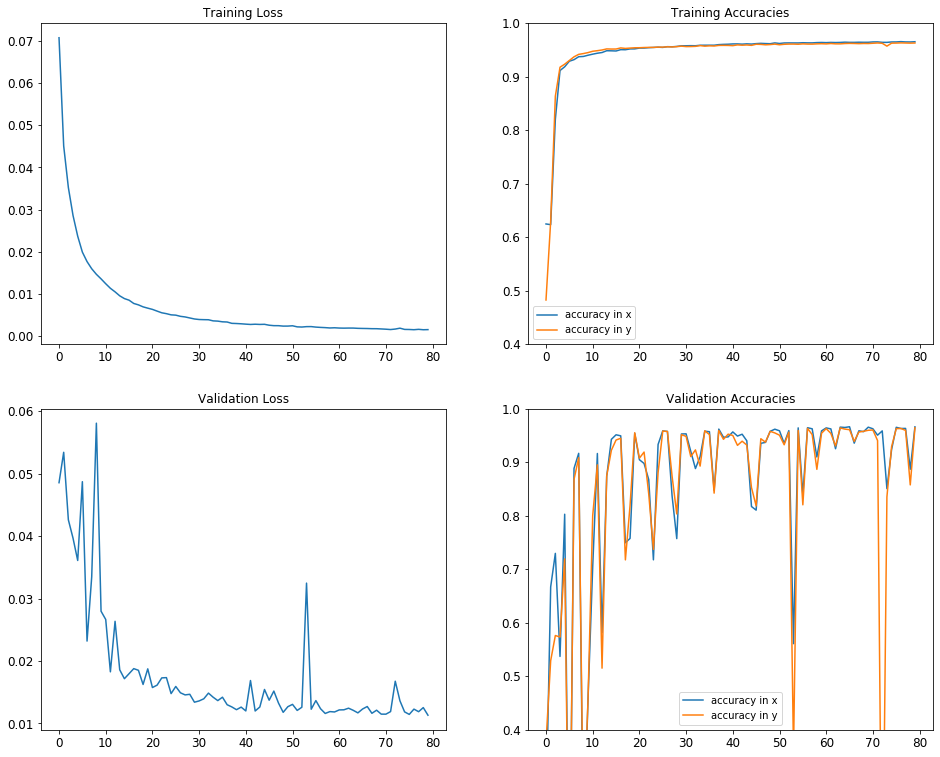

In [16]:
hist = model.history.history
train_loss, train_overall_acc, train_acc_x, train_acc_y = hist['loss'], hist['overall_accuracy'], hist['accuracy_x'], hist['accuracy_y']
val_loss, val_overall_acc, val_acc_x, val_acc_y = hist['val_loss'], hist['val_overall_accuracy'], hist['val_accuracy_x'], hist['val_accuracy_y']

path = LOG_DIR + 'sequential_rot_'
np.save(path + 'train_loss.npy', train_loss)
np.save(path + 'train_overall_acc.npy', train_overall_acc)
np.save(path + 'train_acc_x.npy', train_acc_x)
np.save(path + 'train_acc_y.npy', train_acc_y)
np.save(path + 'val_loss.npy', val_loss)
np.save(path + 'val_overall_acc.npy', val_overall_acc)
np.save(path + 'val_acc_x.npy', val_acc_x)
np.save(path + 'val_acc_y.npy', val_acc_y)

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(train_loss)
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(train_acc_x, label='accuracy in x')
axes[0, 1].plot(train_acc_y, label='accuracy in y')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0.4, 1.0])
axes[0, 1].legend()

axes[1, 0].plot(val_loss)
axes[1, 0].set_title('Validation Loss')

axes[1, 1].plot(val_acc_x, label='accuracy in x')
axes[1, 1].plot(val_acc_y, label='accuracy in y')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0.4, 1.0])
axes[1, 1].legend()

plt.show()

In [17]:
'''
    Evaluating the test loss and accuracies
'''
test_loss, test_overall_acc, test_acc_x, test_acc_y = model.evaluate(rot_test_images, rot_test_flows)
np.save('seq_rot_test.npy', [test_loss, test_overall_acc, test_acc_x, test_acc_y])

444/444 [==============================] - 0s 441us/sample - loss: 0.0056 - overall_accuracy: 0.9651 - accuracy_x: 0.9658 - accuracy_y: 0.9644


In [18]:
'''
    Plotting and comparing the results of the model's predictions and the gourndtruth data for sequential and non-sequential models
'''
def plot_results(img_arr, flw_arr, model):
    img_num = np.random.randint(0, len(img_arr)-1)

    fig, axes = plt.subplots(3, 2,figsize=(12,12))
    axes[0, 0].imshow(img_arr[img_num,:,:,:3])
    axes[0, 0].set_title('Start')    

    axes[0, 1].imshow(img_arr[img_num,:,:,3:])
    axes[0, 1].set_title('Goal')    

    # Find the min and max of the flow.
    fl_min = np.min(flw_arr[img_num])
    fl_max = np.max(flw_arr[img_num])
    fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

    im = axes[1, 0].imshow(flw_arr[img_num,:,:,0])
    im.set_norm(fl_norm)
    axes[1, 0].set_title('Groundtruth Flow in x')
    fig.colorbar(im,ax=axes[1, 0])

    im = axes[1, 1].imshow(flw_arr[img_num,:,:,1])
    im.set_norm(fl_norm)
    axes[1, 1].set_title('Groundtruth Flow in y')
    fig.colorbar(im,ax=axes[1, 1])

    pred = np.squeeze(model.predict(np.expand_dims(img_arr[img_num], axis=0)))

    im = axes[2, 0].imshow(pred[:,:,0])
    im.set_norm(fl_norm)
    axes[2, 0].set_title('Predicted Flow in x')
    fig.colorbar(im,ax=axes[2, 0])

    im = axes[2, 1].imshow(pred[:,:,1])
    im.set_norm(fl_norm)
    axes[2, 1].set_title('Predicted Flow in y')
    fig.colorbar(im,ax=axes[2, 1])

    plt.show()

def plot_results_non_seq(img_arr, flw_arr, model):
    img_num = np.random.randint(0, len(img_arr)-1)

    fig, axes = plt.subplots(3, 2,figsize=(12,12))
    axes[0, 0].imshow(img_arr[0][img_num])
    axes[0, 0].set_title('Start')    

    axes[0, 1].imshow(img_arr[1][img_num])
    axes[0, 1].set_title('Goal')    

    # Find the min and max of the flow.
    fl_min = np.min(flw_arr[img_num])
    fl_max = np.max(flw_arr[img_num])
    fl_norm = colors.Normalize(vmin=fl_min, vmax=fl_max)

    im = axes[1, 0].imshow(flw_arr[img_num,:,:,0])
    im.set_norm(fl_norm)
    axes[1, 0].set_title('Groundtruth Flow in x')
    fig.colorbar(im,ax=axes[1, 0])

    im = axes[1, 1].imshow(flw_arr[img_num,:,:,1])
    im.set_norm(fl_norm)
    axes[1, 1].set_title('Groundtruth Flow in y')
    fig.colorbar(im,ax=axes[1, 1])

    pred = np.squeeze(model.predict((np.expand_dims(img_arr[0][img_num], axis=0), np.expand_dims(img_arr[1][img_num], axis=0))))

    im = axes[2, 0].imshow(pred[:,:,0])
    im.set_norm(fl_norm)
    axes[2, 0].set_title('Predicted Flow in x')
    fig.colorbar(im,ax=axes[2, 0])

    im = axes[2, 1].imshow(pred[:,:,1])
    im.set_norm(fl_norm)
    axes[2, 1].set_title('Predicted Flow in y')
    fig.colorbar(im,ax=axes[2, 1])

    plt.show()

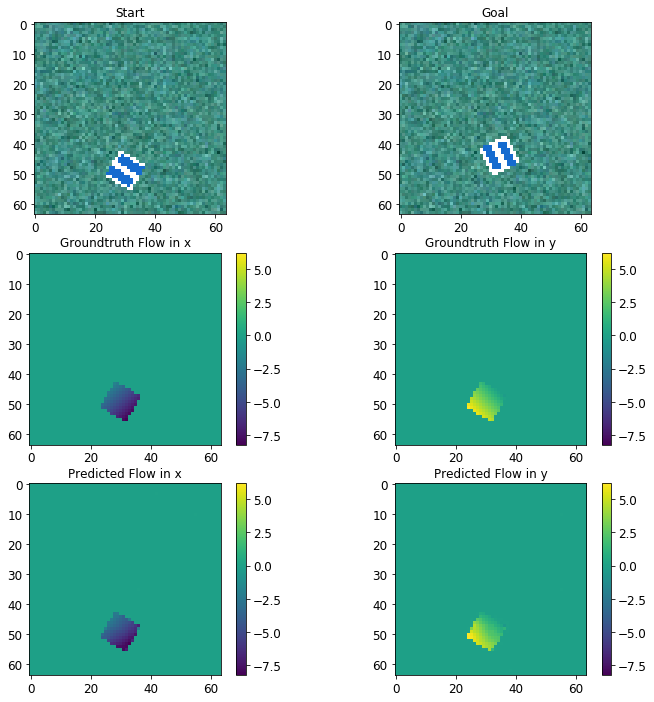

In [19]:
plot_results(rot_test_images, rot_test_flows, model)

In [20]:
clear_gpu(model)

### <a name="3">3. Transfer Learning</a>
***
### <a name="3_1">3.1 Rotation data</a>
***

In [21]:
'''
    I have chosen the following CNN architecture for the optical flow task:
    - Used pretrained VGG, with fixed weights (non-trainable parameters), and without the last 13 layers 
        (these 13 layers may contain conv or max pooling layers)
    - This is because VGG is trained on object classification data set, so the deeper conv layers should be
        more useful in object recognition, but this data set's images have very simple shapes and textures, so we
        need only the low level feature extraction layers 
    - Removed the Input Layer of VGG which has shape of (64,64,3) to replace it with (64,64,6)
    - Added a trainbale Convolution with 3 channels to make the input compatible with the first trained layer of the VGG 
    - Then added 2 Convolution Transpose layers, to upscale the output from (32,32) to (64,64)
        One of these Transpose layers does not upscale the spatial dimensions
    - Then added a final regression layer (Conv with 2 channels)
'''
def create_vgg_model():
    vgg16 = VGG16(include_top=False, input_shape=(64,64,3))
    for layer in vgg16.layers:
        layer.trainable = False
    vgg16._layers.pop(0)
    new_input = Input(shape=(64,64,6))
    x = Conv2D(filters=3, kernel_size=3, padding='same')(new_input)
    for layer in vgg16._layers[:-13]:
        x = layer(x)
    # deconv 1
    deconv1    = Conv2DTranspose(filters=128, kernel_size=3, strides=1, output_padding=0, padding='same')(x)
    batchnorm1 = BatchNormalization()(deconv1)
    act1       = ReLU()(batchnorm1)
    # deconv 2
    deconv2    = Conv2DTranspose(filters=32, kernel_size=3, strides=2, output_padding=1, padding='same')(act1)
    batchnorm2 = BatchNormalization()(deconv2)
    act2       = ReLU()(batchnorm2)
    # regression layer
    regress    = Conv2D(filters=2, kernel_size=3, strides=1, padding='same')(act2)
    model      = Model(new_input, regress)
    model.summary()
    return model

In [22]:
'''
    Loss function:
    - Since this is a regression problem, there are options like mean squared error, mean absolute error, or mean log cosh error
    - MSE: 
        - Reaches the minimum (0) when the prediction is exactly the prediction
        - Will increase if the error > 1 (power 2), in case of outlier
        - Gives more weight to outlier than the Mean Absolute Error
        - Gives a stable solution, differentiable
    - Log Cosh:
        - Smoother than MSE
        - It is (err ** 2) / 2 for small error
        - It is abs(err) - log(2) for large error
        - It works like MSE but won't be strongly affected by the outliers
        - It is twice differentiable everywhere
'''
model = create_vgg_model()
nadam = Nadam(learning_rate=lr,  decay=decay)
model.compile(optimizer=nadam,
              loss=LogCosh(),
              metrics=[overall_accuracy, accuracy_x, accuracy_y])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         165       
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584

In [23]:
trial_name  = "vgg-rot-model-{0}-{1}-batch-size-{2}-lr-{3}-decay-{4}".format(model.optimizer.__class__.__name__, model.loss.__class__.__name__, batch_size, lr, decay)
tensorboard = TensorBoard(log_dir=TB_LOG_DIR + trial_name)

In [24]:
model.fit(x=rot_train_images,
          y=rot_train_flows,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=validation_split,
          callbacks=[tensorboard])

Train on 1581 samples, validate on 279 samples
Epoch 1/30
1581/1581 [==============================] - 4s 2ms/sample - loss: 0.0635 - overall_accuracy: 0.1950 - accuracy_x: 0.2001 - accuracy_y: 0.1899 - val_loss: 0.0574 - val_overall_accuracy: 0.0773 - val_accuracy_x: 0.0186 - val_accuracy_y: 0.1360
Epoch 2/30
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0423 - overall_accuracy: 0.3731 - accuracy_x: 0.3846 - accuracy_y: 0.3616 - val_loss: 0.0399 - val_overall_accuracy: 0.3469 - val_accuracy_x: 0.3669 - val_accuracy_y: 0.3269
Epoch 3/30
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0361 - overall_accuracy: 0.4831 - accuracy_x: 0.5017 - accuracy_y: 0.4645 - val_loss: 0.0362 - val_overall_accuracy: 0.5017 - val_accuracy_x: 0.4927 - val_accuracy_y: 0.5107
Epoch 4/30
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0315 - overall_accuracy: 0.7021 - accuracy_x: 0.7221 - accuracy_y: 0.6821 - val_loss: 0.0346 - val_overall_accu

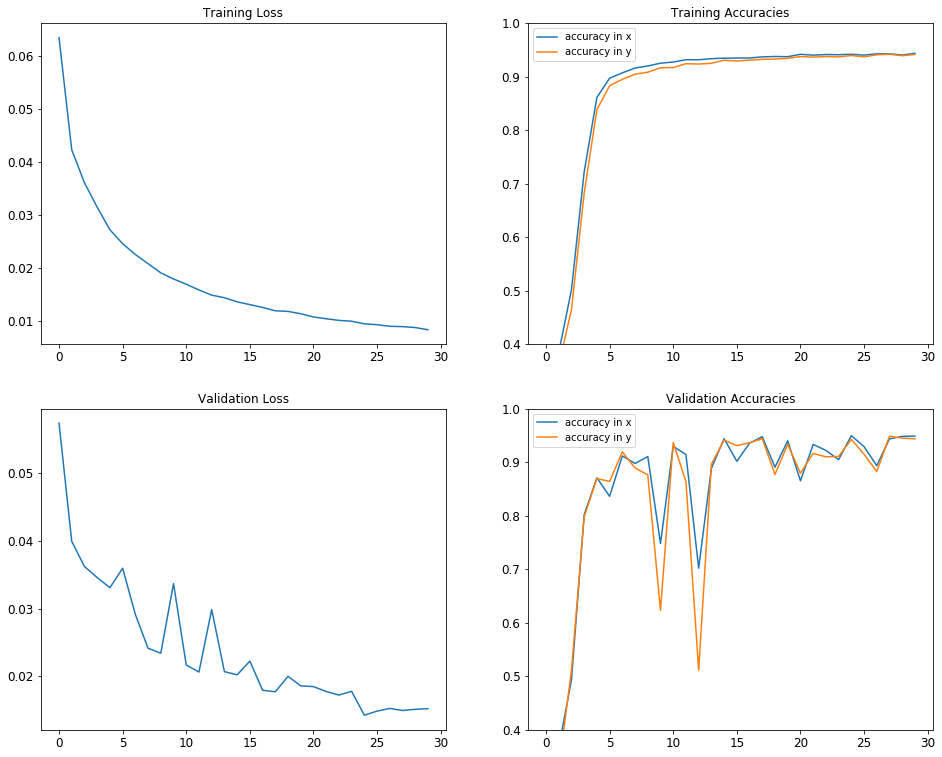

In [25]:
hist = model.history.history
train_loss, train_overall_acc, train_acc_x, train_acc_y = hist['loss'], hist['overall_accuracy'], hist['accuracy_x'], hist['accuracy_y']
val_loss, val_overall_acc, val_acc_x, val_acc_y = hist['val_loss'], hist['val_overall_accuracy'], hist['val_accuracy_x'], hist['val_accuracy_y']

path = LOG_DIR + 'vgg_rot_'
np.save(path + 'train_loss.npy', train_loss)
np.save(path + 'train_overall_acc.npy', train_overall_acc)
np.save(path + 'train_acc_x.npy', train_acc_x)
np.save(path + 'train_acc_y.npy', train_acc_y)
np.save(path + 'val_loss.npy', val_loss)
np.save(path + 'val_overall_acc.npy', val_overall_acc)
np.save(path + 'val_acc_x.npy', val_acc_x)
np.save(path + 'val_acc_y.npy', val_acc_y)

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(train_loss)
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(train_acc_x, label='accuracy in x')
axes[0, 1].plot(train_acc_y, label='accuracy in y')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0.4, 1.0])
axes[0, 1].legend()

axes[1, 0].plot(val_loss)
axes[1, 0].set_title('Validation Loss')

axes[1, 1].plot(val_acc_x, label='accuracy in x')
axes[1, 1].plot(val_acc_y, label='accuracy in y')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0.4, 1.0])
axes[1, 1].legend()

plt.show()

In [26]:
'''
    Actually, in the transfer learning task, the accuracy of the rotation and the mix data sets, are nearly the same.
    But when visualizing the performance, mix data set predictions are better than rotation predictions
'''
test_loss, test_overall_acc, test_acc_x, test_acc_y = model.evaluate(rot_test_images, rot_test_flows)
np.save('vgg_rot_test.npy', [test_loss, test_overall_acc, test_acc_x, test_acc_y])

444/444 [==============================] - 1s 1ms/sample - loss: 0.0123 - overall_accuracy: 0.9456 - accuracy_x: 0.9480 - accuracy_y: 0.9431


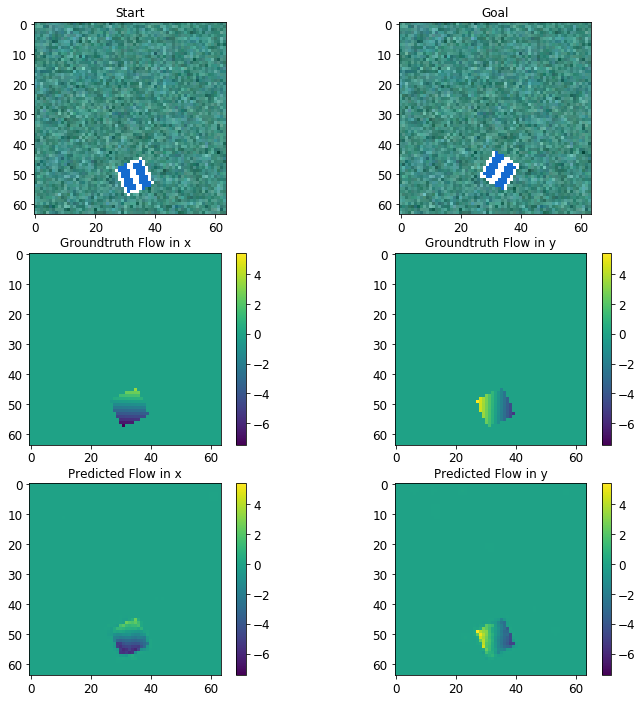

In [27]:
'''
    The results may look good, but these are very blurry
    Observations:
    - VGG weights are trained on classification task on real images
    - The features extacted by VGG in the first layers are low level features (edges, lines, etc..)
    - The following layers may extract features specific to the ImageNet data set (objects)
    - Which do not match this dataset, which has very simple shapes and a background texture
    - That could be a reason why the results are not so good (blurry)
'''
plot_results(rot_test_images, rot_test_flows, model)

In [28]:
clear_gpu(model)

### <a name="3_2">3.2 Mix data</a>
***

In [29]:
'''
    Loss function:
    - Since this is a regression problem, there are options like mean squared error, mean absolute error, or mean log cosh error
    - MSE: 
        - Reaches the minimum (0) when the prediction is exactly the prediction
        - Will increase if the error > 1 (power 2), in case of outlier
        - Gives more weight to outlier than the Mean Absolute Error
        - Gives a stable solution, differentiable
    - Log Cosh:
        - Smoother than MSE
        - It is (err ** 2) / 2 for small error
        - It is abs(err) - log(2) for large error
        - It works like MSE but won't be strongly affected by the outliers
        - It is twice differentiable everywhere
'''
model = create_vgg_model()
nadam = Nadam(learning_rate=lr,  decay=decay)
model.compile(optimizer=nadam,
              loss=LogCosh(),
              metrics=[overall_accuracy, accuracy_x, accuracy_y])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         165       
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584

In [30]:
trial_name  = "vgg-mix-model-{0}-{1}-batch-size-{2}-lr-{3}-decay-{4}".format(model.optimizer.__class__.__name__, model.loss.__class__.__name__, batch_size, lr, decay)
tensorboard = TensorBoard(log_dir=TB_LOG_DIR + trial_name)

In [31]:
model.fit(x=mix_train_images,
          y=mix_train_flows,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=validation_split,
          callbacks=[tensorboard])

Train on 1581 samples, validate on 279 samples
Epoch 1/30
1581/1581 [==============================] - 4s 2ms/sample - loss: 0.0649 - overall_accuracy: 0.2497 - accuracy_x: 0.2516 - accuracy_y: 0.2477 - val_loss: 0.0637 - val_overall_accuracy: 0.1822 - val_accuracy_x: 0.1104 - val_accuracy_y: 0.2539
Epoch 2/30
1581/1581 [==============================] - 4s 2ms/sample - loss: 0.0439 - overall_accuracy: 0.4235 - accuracy_x: 0.4455 - accuracy_y: 0.4016 - val_loss: 0.0455 - val_overall_accuracy: 0.4290 - val_accuracy_x: 0.4101 - val_accuracy_y: 0.4479
Epoch 3/30
1581/1581 [==============================] - 3s 2ms/sample - loss: 0.0391 - overall_accuracy: 0.5920 - accuracy_x: 0.6411 - accuracy_y: 0.5430 - val_loss: 0.0449 - val_overall_accuracy: 0.5269 - val_accuracy_x: 0.5760 - val_accuracy_y: 0.4778
Epoch 4/30
1581/1581 [==============================] - 4s 2ms/sample - loss: 0.0347 - overall_accuracy: 0.8012 - accuracy_x: 0.8256 - accuracy_y: 0.7768 - val_loss: 0.0337 - val_overall_accu

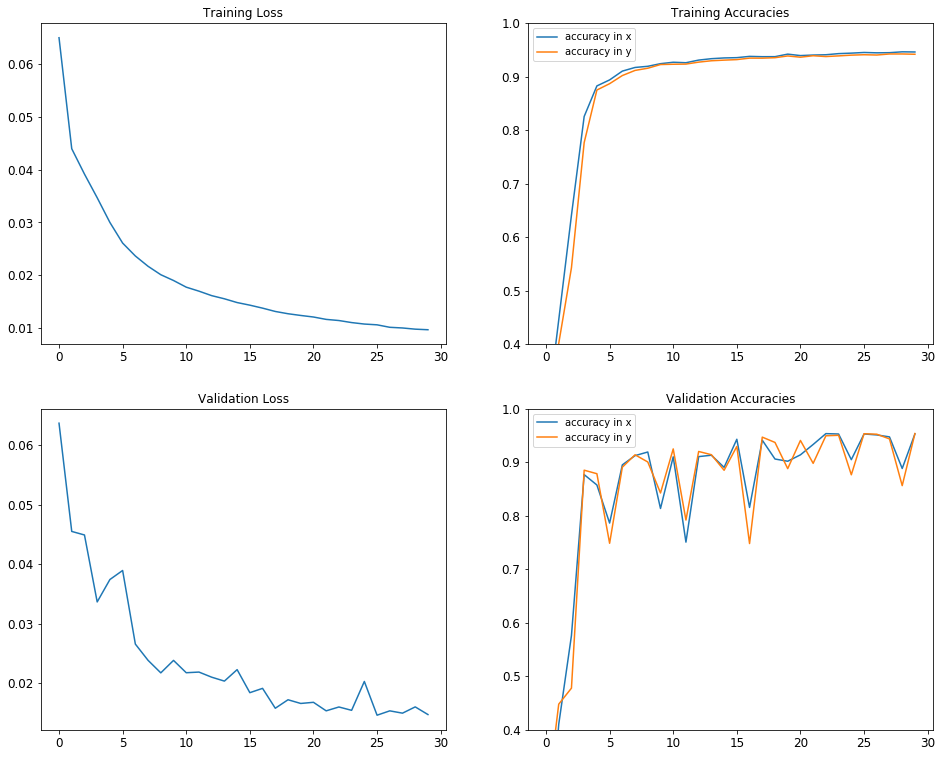

In [32]:
hist = model.history.history
train_loss, train_overall_acc, train_acc_x, train_acc_y = hist['loss'], hist['overall_accuracy'], hist['accuracy_x'], hist['accuracy_y']
val_loss, val_overall_acc, val_acc_x, val_acc_y = hist['val_loss'], hist['val_overall_accuracy'], hist['val_accuracy_x'], hist['val_accuracy_y']

path = LOG_DIR + 'vgg_mix_'
np.save(path + 'train_loss.npy', train_loss)
np.save(path + 'train_overall_acc.npy', train_overall_acc)
np.save(path + 'train_acc_x.npy', train_acc_x)
np.save(path + 'train_acc_y.npy', train_acc_y)
np.save(path + 'val_loss.npy', val_loss)
np.save(path + 'val_overall_acc.npy', val_overall_acc)
np.save(path + 'val_acc_x.npy', val_acc_x)
np.save(path + 'val_acc_y.npy', val_acc_y)

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(train_loss)
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(train_acc_x, label='accuracy in x')
axes[0, 1].plot(train_acc_y, label='accuracy in y')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0.4, 1.0])
axes[0, 1].legend()

axes[1, 0].plot(val_loss)
axes[1, 0].set_title('Validation Loss')

axes[1, 1].plot(val_acc_x, label='accuracy in x')
axes[1, 1].plot(val_acc_y, label='accuracy in y')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0.4, 1.0])
axes[1, 1].legend()

plt.show()

In [33]:
'''
    Actually, in the transfer learning task, the accuracy of the rotation and the mix data sets, are nearly the same.
    But when visualizing the performance, mix data set predictions are better than rotation predictions
'''
test_loss, test_overall_acc, test_acc_x, test_acc_y = model.evaluate(mix_test_images, mix_test_flows)
np.save('vgg_mix_test.npy', [test_loss, test_overall_acc, test_acc_x, test_acc_y])

444/444 [==============================] - 0s 656us/sample - loss: 0.0126 - overall_accuracy: 0.9544 - accuracy_x: 0.9540 - accuracy_y: 0.9547


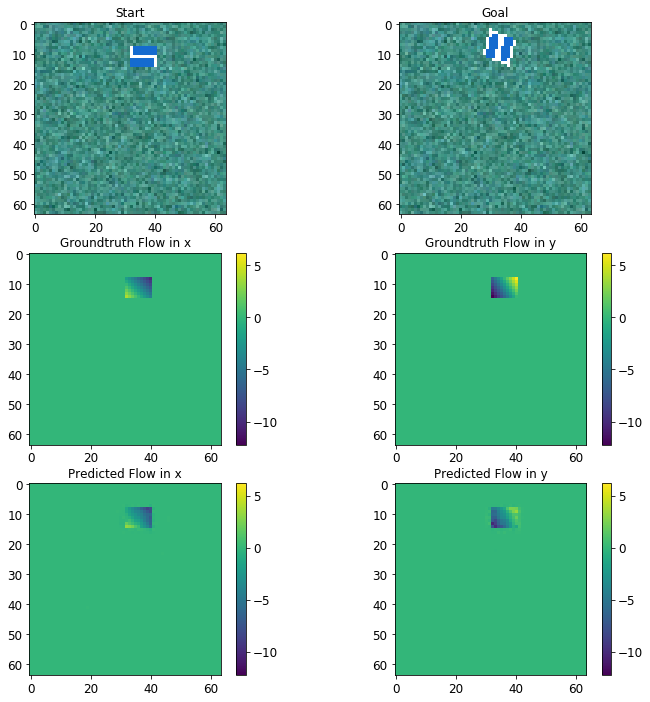

In [34]:
plot_results(mix_test_images, mix_test_flows, model)

In [35]:
clear_gpu(model)

### <a name="4">4. Non-sequential Model (Bonus)</a>
***
### <a name="4_1">4.1 Rotation data</a>
***

In [36]:
'''
    I have chose the following CNN architecture for the optical flow task:
    - I have used the siamese architecture for this part
    - The network has two input pipelines, each with a (64,64,3) shape
    - Each pipeline has 3 identical convolutional blocks (conv, batchnorm, activation)
    - Max pooling is not used, instead, strided convolutions with padding is 'valid' is used to reduce the spatial dimensions
    - Whenever the spatial dimensions are reduced (halfed), the number of filters is doubled
    - Then both pipelines are concatenated as channels and applied to a convolution block
    - Then Convolution transpose is applied to upscale the feature maps to the groundtruth size (64,64)
    - Then a final regression layer (conv) with number of filters 2 is applied, with linear activation
'''
def create_non_seq_model():
    left_input  = Input(shape=(64, 64, 3))
    right_input = Input(shape=(64, 64, 3))

    with tf.name_scope("LeftNetwork"):
        with tf.name_scope("ConvBlock1"):
            l_block1_conv      = Conv2D(filters=48, kernel_size=3, strides=2, padding='valid')(left_input)
            l_block1_batchnorm = BatchNormalization()(l_block1_conv)
            l_block1_act       = ReLU()(l_block1_batchnorm)
        with tf.name_scope("ConvBlock2"):
            l_block2_conv      = Conv2D(filters=48, kernel_size=3, strides=1, padding='same')(l_block1_act)
            l_block2_batchnorm = BatchNormalization()(l_block2_conv)
            l_block2_act       = ReLU()(l_block2_batchnorm)
        with tf.name_scope("ConvBlock3"):
            l_block3_conv      = Conv2D(filters=96, kernel_size=3, strides=2, padding='valid')(l_block2_act)
            l_block3_batchnorm = BatchNormalization()(l_block3_conv)
            l_block3_act       = ReLU()(l_block3_batchnorm)

    with tf.name_scope("RightNetwork"):
        with tf.name_scope("ConvBlock1"):
            r_block1_conv      = Conv2D(filters=48, kernel_size=3, strides=2, padding='valid')(right_input)
            r_block1_batchnorm = BatchNormalization()(r_block1_conv)
            r_block1_act       = ReLU()(r_block1_batchnorm)
        with tf.name_scope("ConvBlock2"):
            r_block2_conv      = Conv2D(filters=48, kernel_size=3, strides=1, padding='same')(r_block1_act)
            r_block2_batchnorm = BatchNormalization()(r_block2_conv)
            r_block2_act       = ReLU()(r_block2_batchnorm)
        with tf.name_scope("ConvBlock3"):
            r_block3_conv      = Conv2D(filters=96, kernel_size=3, strides=2, padding='valid')(r_block2_act)
            r_block3_batchnorm = BatchNormalization()(r_block3_conv)
            r_block3_act       = ReLU()(r_block3_batchnorm)

    with tf.name_scope("MergedNetwork"):
        with tf.name_scope("Concatenate"):
            concat = concatenate([l_block3_act, r_block3_act])
        with tf.name_scope("ConvBlock4"):
            block4_conv      = Conv2D(filters=192, kernel_size=3, strides=2, padding='valid')(concat)
            block4_batchnorm = BatchNormalization()(block4_conv)
            block4_act       = ReLU()(block4_batchnorm)
        with tf.name_scope("DeconvBlock5"):
            block5_deconv      = Conv2DTranspose(filters=96, kernel_size=3, strides=2, padding='valid')(block4_act)
            block5_batchnorm = BatchNormalization()(block5_deconv)
            block5_act       = ReLU()(block5_batchnorm)
        with tf.name_scope("DeconvBlock6"):
            block6_deconv    = Conv2DTranspose(filters=48, kernel_size=3, strides=2, padding='valid', output_padding=1)(block5_act)
            block6_batchnorm = BatchNormalization()(block6_deconv)
            block6_act       = ReLU()(block6_batchnorm)    
        with tf.name_scope("DeconvBlock7"):
            block7_deconv    = Conv2DTranspose(filters=24, kernel_size=3, strides=2, padding='same', output_padding=1)(block6_act)
            block7_batchnorm = BatchNormalization()(block7_deconv)
            block7_act       = ReLU()(block7_batchnorm)    
        with tf.name_scope("RegressLayer"):
            regress           = Conv2D(filters=2, kernel_size=3, strides=1, padding='same')(block7_act)

    model = Model([left_input, right_input], regress)
    model.summary()
    return model

In [37]:
'''
    Loss function:
    - Since this is a regression problem, there are options like mean squared error, mean absolute error, or mean log cosh error
    - MSE: 
        - Reaches the minimum (0) when the prediction is exactly the prediction
        - Will increase if the error > 1 (power 2), in case of outlier
        - Gives more weight to outlier than the Mean Absolute Error
        - Gives a stable solution, differentiable
    - Log Cosh:
        - Smoother than MSE
        - It is (err ** 2) / 2 for small error
        - It is abs(err) - log(2) for large error
        - It works like MSE but won't be strongly affected by the outliers
        - It is twice differentiable everywhere
'''
model = create_non_seq_model()
nadam = Nadam(learning_rate=lr,  decay=decay)
model.compile(optimizer=nadam,
              loss=LogCosh(),
              metrics=[overall_accuracy, accuracy_x, accuracy_y])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 48)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 31, 31, 48)   1344        input_2[0][0]                    
______________________________________________________________________________________________

In [38]:
trial_name  = "bonus-rot-model-{0}-{1}-batch-size-{2}-lr-{3}-decay-{4}".format(model.optimizer.__class__.__name__, model.loss.__class__.__name__, batch_size, lr, decay)
tensorboard = TensorBoard(log_dir=TB_LOG_DIR + trial_name)

In [39]:
model.fit(x=(rot_train_images[:,:,:,:3], rot_train_images[:,:,:,3:6]),
          y=rot_train_flows,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=validation_split,
          callbacks=[tensorboard])

Train on 1581 samples, validate on 279 samples
Epoch 1/30
1581/1581 [==============================] - 6s 4ms/sample - loss: 0.0754 - overall_accuracy: 0.5453 - accuracy_x: 0.5596 - accuracy_y: 0.5309 - val_loss: 0.0755 - val_overall_accuracy: 0.5078 - val_accuracy_x: 0.3114 - val_accuracy_y: 0.7042
Epoch 2/30
1581/1581 [==============================] - 5s 3ms/sample - loss: 0.0523 - overall_accuracy: 0.7778 - accuracy_x: 0.8192 - accuracy_y: 0.7364 - val_loss: 0.0779 - val_overall_accuracy: 0.5403 - val_accuracy_x: 0.6449 - val_accuracy_y: 0.4356
Epoch 3/30
1581/1581 [==============================] - 5s 3ms/sample - loss: 0.0429 - overall_accuracy: 0.8883 - accuracy_x: 0.8959 - accuracy_y: 0.8806 - val_loss: 0.0678 - val_overall_accuracy: 0.8968 - val_accuracy_x: 0.9111 - val_accuracy_y: 0.8826
Epoch 4/30
1581/1581 [==============================] - 5s 3ms/sample - loss: 0.0355 - overall_accuracy: 0.9189 - accuracy_x: 0.9169 - accuracy_y: 0.9209 - val_loss: 0.0540 - val_overall_accu

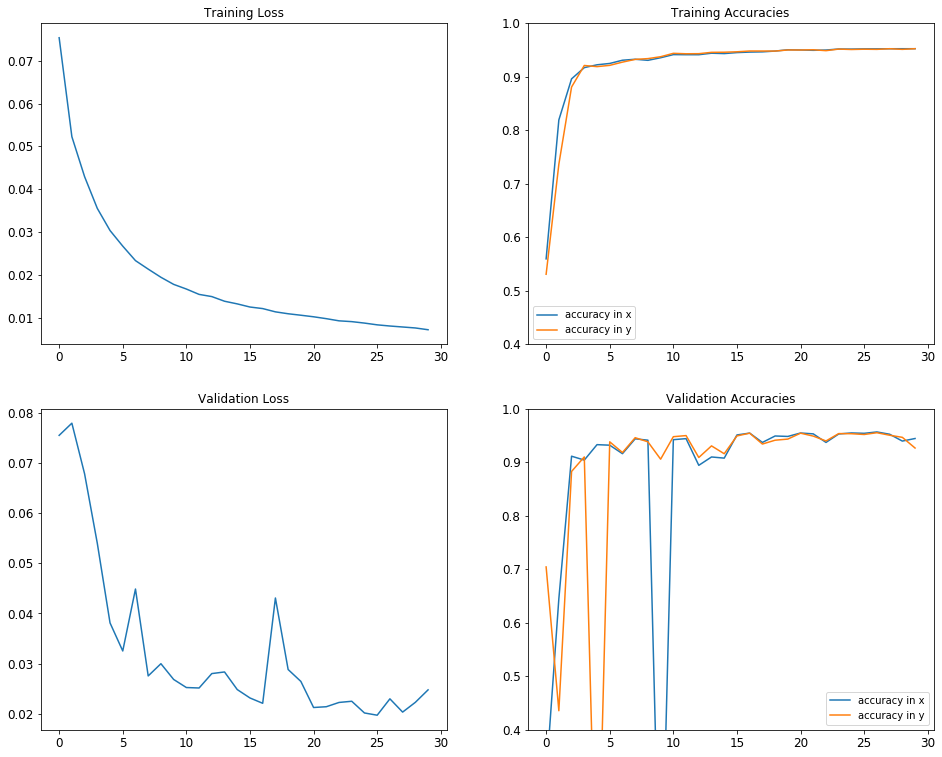

In [40]:
hist = model.history.history
train_loss, train_overall_acc, train_acc_x, train_acc_y = hist['loss'], hist['overall_accuracy'], hist['accuracy_x'], hist['accuracy_y']
val_loss, val_overall_acc, val_acc_x, val_acc_y = hist['val_loss'], hist['val_overall_accuracy'], hist['val_accuracy_x'], hist['val_accuracy_y']

path = LOG_DIR + 'non_seq_rot_'
np.save(path + 'train_loss.npy', train_loss)
np.save(path + 'train_overall_acc.npy', train_overall_acc)
np.save(path + 'train_acc_x.npy', train_acc_x)
np.save(path + 'train_acc_y.npy', train_acc_y)
np.save(path + 'val_loss.npy', val_loss)
np.save(path + 'val_overall_acc.npy', val_overall_acc)
np.save(path + 'val_acc_x.npy', val_acc_x)
np.save(path + 'val_acc_y.npy', val_acc_y)

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(train_loss)
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(train_acc_x, label='accuracy in x')
axes[0, 1].plot(train_acc_y, label='accuracy in y')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0.4, 1.0])
axes[0, 1].legend()

axes[1, 0].plot(val_loss)
axes[1, 0].set_title('Validation Loss')

axes[1, 1].plot(val_acc_x, label='accuracy in x')
axes[1, 1].plot(val_acc_y, label='accuracy in y')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0.4, 1.0])
axes[1, 1].legend()

plt.show()

In [41]:
test_loss, test_overall_acc, test_acc_x, test_acc_y = model.evaluate((rot_test_images[:,:,:,:3], rot_test_images[:,:,:,3:6]), rot_test_flows)
np.save('non_seq_rot_test.npy', [test_loss, test_overall_acc, test_acc_x, test_acc_y])

444/444 [==============================] - 0s 485us/sample - loss: 0.0184 - overall_accuracy: 0.9382 - accuracy_x: 0.9459 - accuracy_y: 0.9306


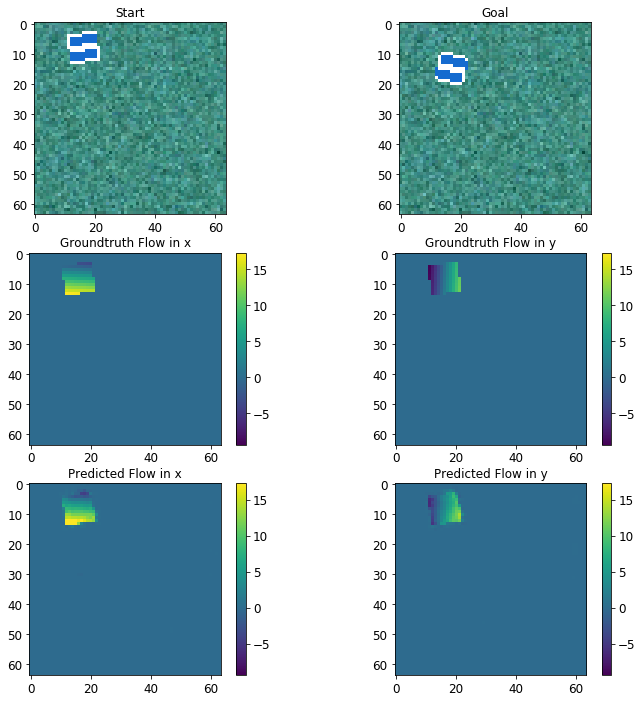

In [42]:
plot_results_non_seq((rot_test_images[:,:,:,:3], rot_test_images[:,:,:,3:6]), rot_test_flows, model)

In [43]:
clear_gpu(model)

### <a name="4_2">4.2 Mix data</a>
***

In [56]:
'''
    Loss function:
    - Since this is a regression problem, there are options like mean squared error, mean absolute error, or mean log cosh error
    - MSE: 
        - Reaches the minimum (0) when the prediction is exactly the prediction
        - Will increase if the error > 1 (power 2), in case of outlier
        - Gives more weight to outlier than the Mean Absolute Error
        - Gives a stable solution, differentiable
    - Log Cosh:
        - Smoother than MSE
        - It is (err ** 2) / 2 for small error
        - It is abs(err) - log(2) for large error
        - It works like MSE but won't be strongly affected by the outliers
        - It is twice differentiable everywhere
'''
model = create_non_seq_model()
nadam = Nadam(learning_rate=lr,  decay=decay)
model.compile(optimizer=nadam,
              loss=LogCosh(),
              metrics=[overall_accuracy, accuracy_x, accuracy_y])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 48)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 31, 31, 48)   1344        input_2[0][0]                    
______________________________________________________________________________________________

In [57]:
trial_name  = "bonus-mix-model-{0}-{1}-batch-size-{2}-lr-{3}-decay-{4}".format(model.optimizer.__class__.__name__, model.loss.__class__.__name__, batch_size, lr, decay)
tensorboard = TensorBoard(log_dir=TB_LOG_DIR + trial_name)

In [58]:
model.fit(x=(mix_train_images[:,:,:,:3], mix_train_images[:,:,:,3:6]),
          y=mix_train_flows,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=validation_split,
          callbacks=[tensorboard])

Train on 1581 samples, validate on 279 samples
Epoch 1/30
1581/1581 [==============================] - 6s 4ms/sample - loss: 0.0798 - overall_accuracy: 0.6148 - accuracy_x: 0.5546 - accuracy_y: 0.6749 - val_loss: 0.0775 - val_overall_accuracy: 0.0631 - val_accuracy_x: 0.0338 - val_accuracy_y: 0.0924
Epoch 2/30
1581/1581 [==============================] - 4s 3ms/sample - loss: 0.0661 - overall_accuracy: 0.6855 - accuracy_x: 0.6690 - accuracy_y: 0.7019 - val_loss: 0.0652 - val_overall_accuracy: 0.6150 - val_accuracy_x: 0.5621 - val_accuracy_y: 0.6679
Epoch 3/30
1581/1581 [==============================] - 5s 3ms/sample - loss: 0.0507 - overall_accuracy: 0.7656 - accuracy_x: 0.7878 - accuracy_y: 0.7435 - val_loss: 0.0617 - val_overall_accuracy: 0.3484 - val_accuracy_x: 0.3705 - val_accuracy_y: 0.3264
Epoch 4/30
1581/1581 [==============================] - 4s 3ms/sample - loss: 0.0410 - overall_accuracy: 0.8911 - accuracy_x: 0.8819 - accuracy_y: 0.9003 - val_loss: 0.0460 - val_overall_accu

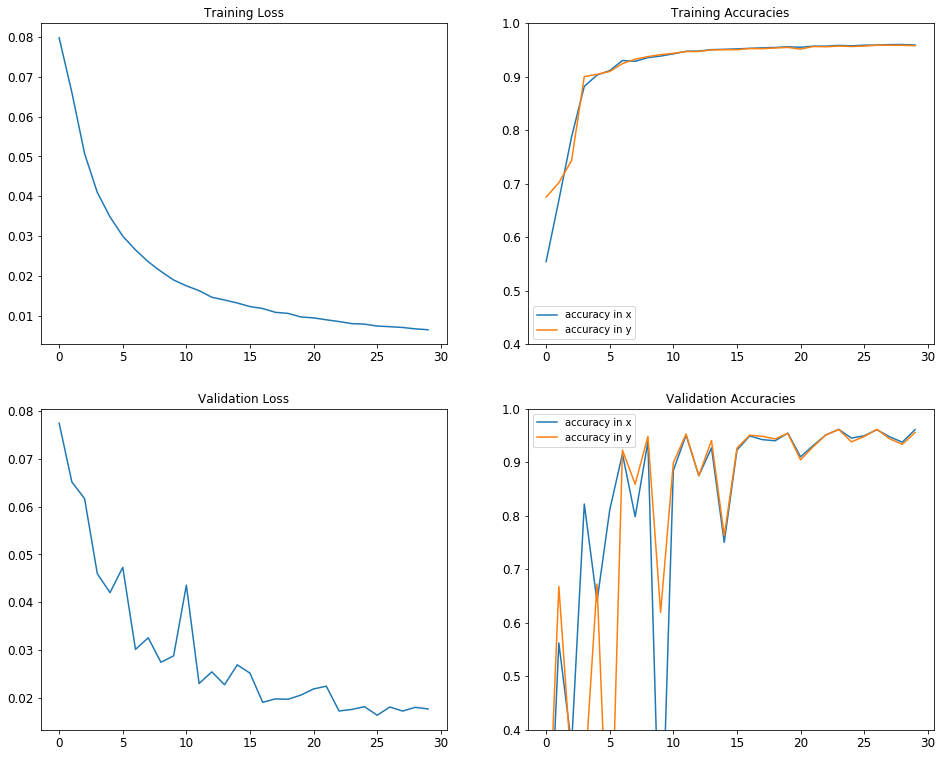

In [59]:
hist = model.history.history
train_loss, train_overall_acc, train_acc_x, train_acc_y = hist['loss'], hist['overall_accuracy'], hist['accuracy_x'], hist['accuracy_y']
val_loss, val_overall_acc, val_acc_x, val_acc_y = hist['val_loss'], hist['val_overall_accuracy'], hist['val_accuracy_x'], hist['val_accuracy_y']

path = LOG_DIR + 'non_seq_mix_'
np.save(path + 'train_loss.npy', train_loss)
np.save(path + 'train_overall_acc.npy', train_overall_acc)
np.save(path + 'train_acc_x.npy', train_acc_x)
np.save(path + 'train_acc_y.npy', train_acc_y)
np.save(path + 'val_loss.npy', val_loss)
np.save(path + 'val_overall_acc.npy', val_overall_acc)
np.save(path + 'val_acc_x.npy', val_acc_x)
np.save(path + 'val_acc_y.npy', val_acc_y)

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(train_loss)
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(train_acc_x, label='accuracy in x')
axes[0, 1].plot(train_acc_y, label='accuracy in y')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0.4, 1.0])
axes[0, 1].legend()

axes[1, 0].plot(val_loss)
axes[1, 0].set_title('Validation Loss')

axes[1, 1].plot(val_acc_x, label='accuracy in x')
axes[1, 1].plot(val_acc_y, label='accuracy in y')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0.4, 1.0])
axes[1, 1].legend()

plt.show()

In [60]:
test_loss, test_overall_acc, test_acc_x, test_acc_y = model.evaluate((mix_test_images[:,:,:,:3], mix_test_images[:,:,:,3:6]), mix_test_flows)
np.save('non_seq_mix_test.npy', [test_loss, test_overall_acc, test_acc_x, test_acc_y])

444/444 [==============================] - 0s 429us/sample - loss: 0.0132 - overall_accuracy: 0.9576 - accuracy_x: 0.9603 - accuracy_y: 0.9550


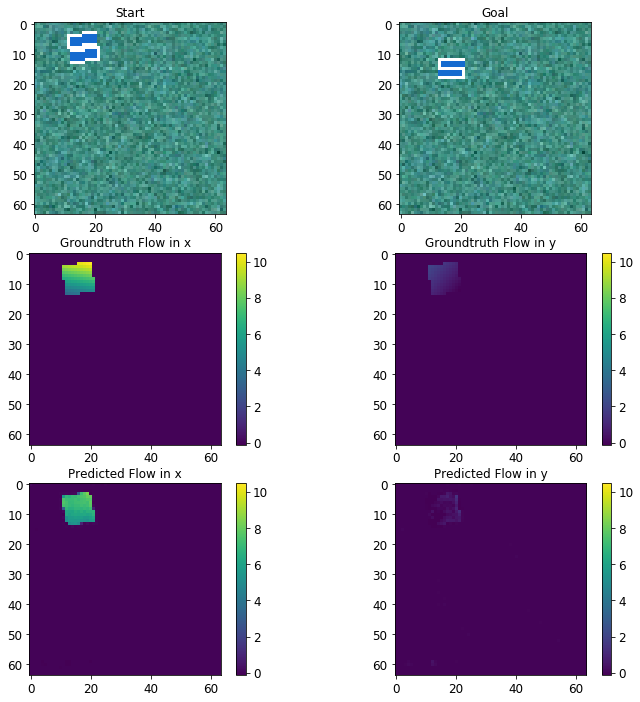

In [61]:
plot_results_non_seq((mix_test_images[:,:,:,:3], mix_test_images[:,:,:,3:6]), mix_test_flows, model)

In [62]:
clear_gpu(model)

### <a name="5">5. Visualizing and comparing results</a>
***
### <a name="5_1">5.1 Rotation data</a>
***

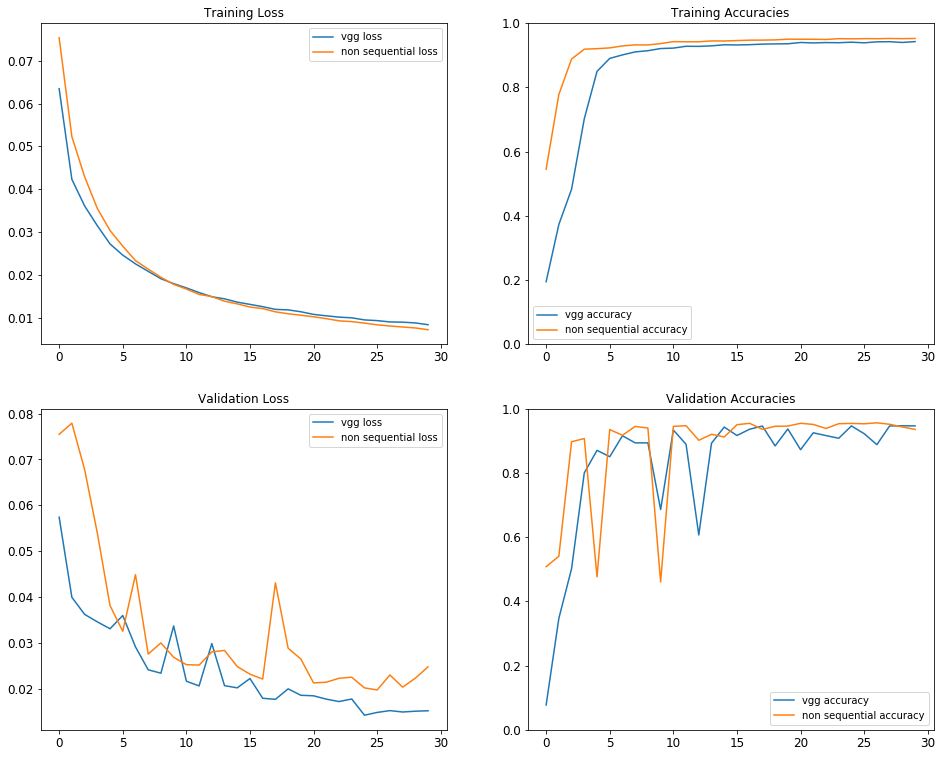

In [63]:
vgg_train_loss = np.load(LOG_DIR + 'vgg_rot_train_loss.npy')
vgg_train_overall_acc = np.load(LOG_DIR + 'vgg_rot_train_overall_acc.npy')
vgg_val_loss   = np.load(LOG_DIR + 'vgg_rot_val_loss.npy')
vgg_val_overall_acc = np.load(LOG_DIR + 'vgg_rot_val_overall_acc.npy')

non_seq_train_loss = np.load(LOG_DIR + 'non_seq_rot_train_loss.npy')
non_seq_train_overall_acc = np.load(LOG_DIR + 'non_seq_rot_train_overall_acc.npy')
non_seq_val_loss   = np.load(LOG_DIR + 'non_seq_rot_val_loss.npy')
non_seq_val_overall_acc = np.load(LOG_DIR + 'non_seq_rot_val_overall_acc.npy')

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(vgg_train_loss, label='vgg loss')
axes[0, 0].plot(non_seq_train_loss, label='non sequential loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(vgg_train_overall_acc, label='vgg accuracy')
axes[0, 1].plot(non_seq_train_overall_acc, label='non sequential accuracy')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0., 1.0])
axes[0, 1].legend()

axes[1, 0].plot(vgg_val_loss, label='vgg loss')
axes[1, 0].plot(non_seq_val_loss, label='non sequential loss')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Loss')    

axes[1, 1].plot(vgg_val_overall_acc, label='vgg accuracy')
axes[1, 1].plot(non_seq_val_overall_acc, label='non sequential accuracy')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0., 1.0])
axes[1, 1].legend()

plt.show()

### <a name="5_2">5.2 Mix data</a>
***

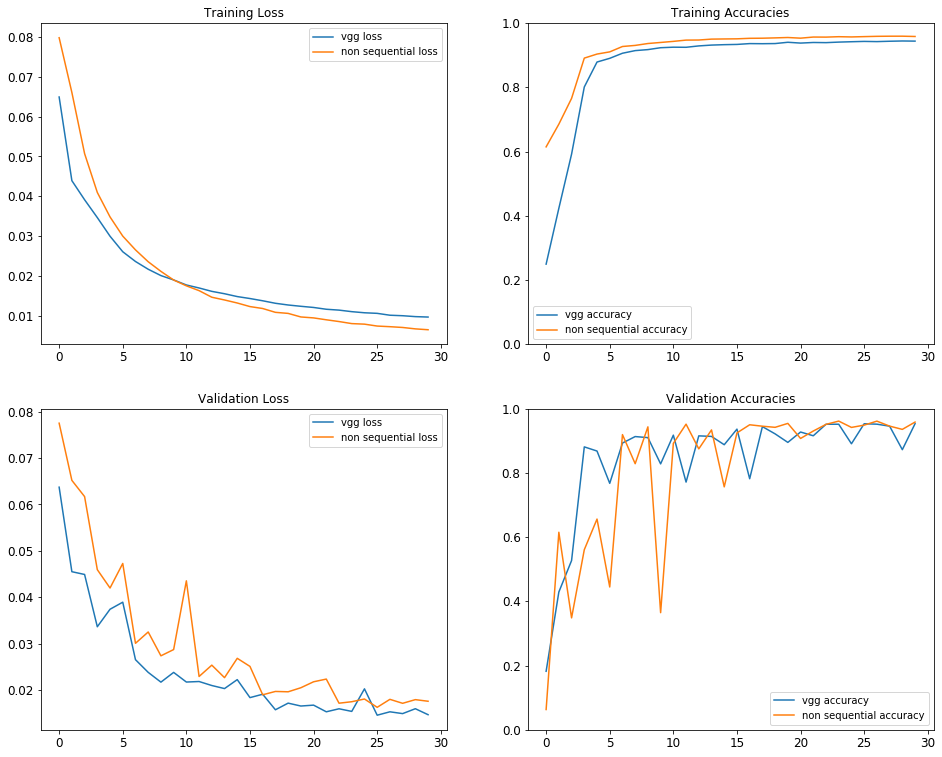

In [64]:
vgg_train_loss = np.load(LOG_DIR + 'vgg_mix_train_loss.npy')
vgg_train_overall_acc = np.load(LOG_DIR + 'vgg_mix_train_overall_acc.npy')
vgg_val_loss   = np.load(LOG_DIR + 'vgg_mix_val_loss.npy')
vgg_val_overall_acc = np.load(LOG_DIR + 'vgg_mix_val_overall_acc.npy')

non_seq_train_loss = np.load(LOG_DIR + 'non_seq_mix_train_loss.npy')
non_seq_train_overall_acc = np.load(LOG_DIR + 'non_seq_mix_train_overall_acc.npy')
non_seq_val_loss   = np.load(LOG_DIR + 'non_seq_mix_val_loss.npy')
non_seq_val_overall_acc = np.load(LOG_DIR + 'non_seq_mix_val_overall_acc.npy')

fig, axes = plt.subplots(2, 2,figsize=(16, 13))
axes[0, 0].plot(vgg_train_loss, label='vgg loss')
axes[0, 0].plot(non_seq_train_loss, label='non sequential loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')    

axes[0, 1].plot(vgg_train_overall_acc, label='vgg accuracy')
axes[0, 1].plot(non_seq_train_overall_acc, label='non sequential accuracy')
axes[0, 1].set_title('Training Accuracies') 
axes[0, 1].set_ylim([0., 1.0])
axes[0, 1].legend()

axes[1, 0].plot(vgg_val_loss, label='vgg loss')
axes[1, 0].plot(non_seq_val_loss, label='non sequential loss')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Loss')    

axes[1, 1].plot(vgg_val_overall_acc, label='vgg accuracy')
axes[1, 1].plot(non_seq_val_overall_acc, label='non sequential accuracy')
axes[1, 1].set_title('Validation Accuracies') 
axes[1, 1].set_ylim([0., 1.0])
axes[1, 1].legend()

plt.show()

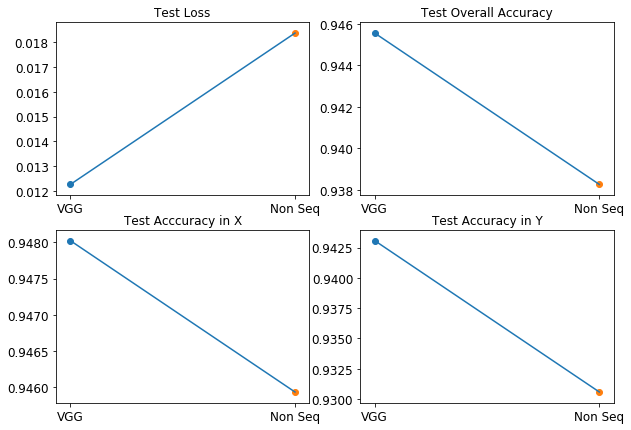

In [65]:
'''
    Test loss and accuracy for Rotation data (only for vgg and non-sequential model after training for 30 epochs)
    These plots show that the non-sequential model is better in terms of loss and accuracy metrics measures
'''
vgg_rot_test_loss, vgg_rot_test_overall_acc, vgg_rot_test_acc_x, vgg_rot_test_acc_y = np.load('vgg_rot_test.npy')
vgg_mix_test_loss, vgg_mix_test_overall_acc, vgg_mix_test_acc_x, vgg_mix_test_acc_y = np.load('vgg_mix_test.npy')
non_seq_rot_test_loss, non_seq_rot_test_overall_acc, non_seq_rot_test_acc_x, non_seq_rot_test_acc_y = np.load('non_seq_rot_test.npy')
non_seq_mix_test_loss, non_seq_mix_test_overall_acc, non_seq_mix_test_acc_x, non_seq_mix_test_acc_y = np.load('non_seq_mix_test.npy')

fig, axes = plt.subplots(2, 2,figsize=(10, 7))
x = [0,1]
labels = ['VGG', 'Non Seq']
axes[0, 0].plot([vgg_rot_test_loss, non_seq_rot_test_loss])
axes[0, 0].scatter(x=labels[0], y=vgg_rot_test_loss)
axes[0, 0].scatter(x=labels[1], y=non_seq_rot_test_loss)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(labels, minor=False)
axes[0, 0].set_title('Test Loss')    

axes[0, 1].plot([vgg_rot_test_overall_acc, non_seq_rot_test_overall_acc])
axes[0, 1].scatter(x=labels[0], y=vgg_rot_test_overall_acc)
axes[0, 1].scatter(x=labels[1], y=non_seq_rot_test_overall_acc)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(labels, minor=False)
axes[0, 1].set_title('Test Overall Accuracy')    

axes[1, 0].plot([vgg_rot_test_acc_x, non_seq_rot_test_acc_x])
axes[1, 0].scatter(x=labels[0], y=vgg_rot_test_acc_x)
axes[1, 0].scatter(x=labels[1], y=non_seq_rot_test_acc_x)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, minor=False)
axes[1, 0].set_title('Test Acccuracy in X')    

axes[1, 1].plot([vgg_rot_test_acc_y, non_seq_rot_test_acc_y])
axes[1, 1].scatter(x=labels[0], y=vgg_rot_test_acc_y)
axes[1, 1].scatter(x=labels[1], y=non_seq_rot_test_acc_y)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels, minor=False)
axes[1, 1].set_title('Test Accuracy in Y')    

plt.show()

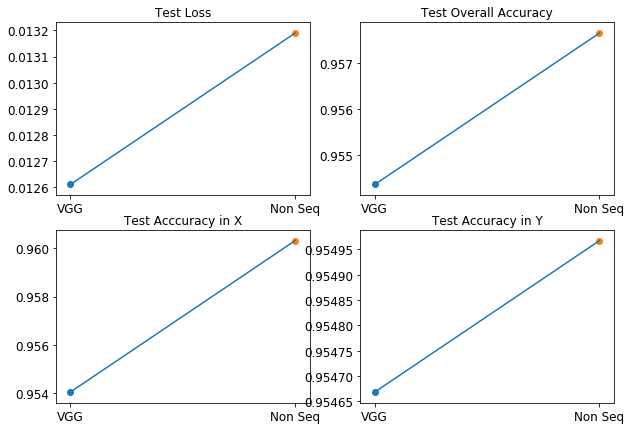

In [68]:
'''
    Comparing test results for Mix data
    It looks like the accuracy is better for the non-sequential model, but the loss is higher than VGG pre-trained model
'''
fig, axes = plt.subplots(2, 2,figsize=(10, 7))
x = [0,1]
labels = ['VGG', 'Non Seq']
axes[0, 0].plot([vgg_mix_test_loss, non_seq_mix_test_loss])
axes[0, 0].scatter(x=labels[0], y=vgg_mix_test_loss)
axes[0, 0].scatter(x=labels[1], y=non_seq_mix_test_loss)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(labels, minor=False)
axes[0, 0].set_title('Test Loss')    

axes[0, 1].plot([vgg_mix_test_overall_acc, non_seq_mix_test_overall_acc])
axes[0, 1].scatter(x=labels[0], y=vgg_mix_test_overall_acc)
axes[0, 1].scatter(x=labels[1], y=non_seq_mix_test_overall_acc)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(labels, minor=False)
axes[0, 1].set_title('Test Overall Accuracy')    

axes[1, 0].plot([vgg_mix_test_acc_x, non_seq_mix_test_acc_x])
axes[1, 0].scatter(x=labels[0], y=vgg_mix_test_acc_x)
axes[1, 0].scatter(x=labels[1], y=non_seq_mix_test_acc_x)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, minor=False)
axes[1, 0].set_title('Test Acccuracy in X')    

axes[1, 1].plot([vgg_mix_test_acc_y, non_seq_mix_test_acc_y])
axes[1, 1].scatter(x=labels[0], y=vgg_mix_test_acc_y)
axes[1, 1].scatter(x=labels[1], y=non_seq_mix_test_acc_y)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels, minor=False)
axes[1, 1].set_title('Test Accuracy in Y')    

plt.show()